# House Price Forecast
**W207-1 Final Project, Aug 28th 2017**

**Team Member: Ryan Delgado, Cynthia Hu, Joseph Kunkel, John Tabbone **

## Summary
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Load Data

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context = 'notebook')

# SK-learn libraries for learning
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import *
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

# SK-learn libraries for evaluation.
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from sklearn import metrics

# Others
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr

C:\Users\cyhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\cyhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
df = pd.read_csv("C:/Users/cyhu/Desktop/w207/W207_Summer/Final Project/train.csv")
print('data shape: ', df.shape)
df.info()

data shape:  (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Ext

## Exploratory Analysis

First, let's check missing data. The top 5 missing variables - Alley, FireplaceQu, PoolQC, Fence, MiscFeature and LotFrontage should be excluded from modeling as they have very high missing percentage (15%+).

In [5]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Next, separate categorical variables and numerica variables. Looking at the data_description.txt files, a few of these columns are actually categorical features that are labeled with numbers. We'll filter those out, and also filter out the SalePrice and Id columns.

In [6]:
numeric_features = df.columns[df.dtypes != object].tolist()
for col in ['Id', 'SalePrice', 'MSSubClass', 'OverallQual', 'OverallCond']:
    numeric_features.remove(col)

categorical_features = df.columns[df.dtypes == object].tolist()
categorical_features.extend(['MSSubClass', 'OverallQual', 'OverallCond'])

### Sales Price

Now let's examine key variables. First, the response variable - Sales Price which is slightly right skewed. Though after log tranforming, it's close to normal distribution, there is no need for such transformation per central limit theorem.

Summary Statistics of Sales Price:
 count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


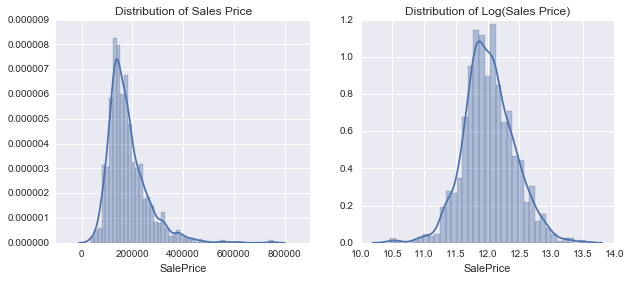

In [13]:
# summary statistics of target variable and sanity check
print("Summary Statistics of Sales Price:\n", df['SalePrice'].describe())

# histgram to explore distribution
plt.subplots(figsize=(10, 4))
plt.subplot(1,2,1)
sns.distplot(df['SalePrice'])
plt.title('Distribution of Sales Price')
plt.subplot(1,2,2)
sns.distplot(np.log(df['SalePrice']))
plt.title('Distribution of Log(Sales Price)')

### Sales Price vs. Numerical Variables

Next, we will examine the relationship between sales price and numerical variables. From the correlation matrix below, we can see that GrLivArea has very high correlation with TotRmsAbvGrd which may indicate collinearity. 

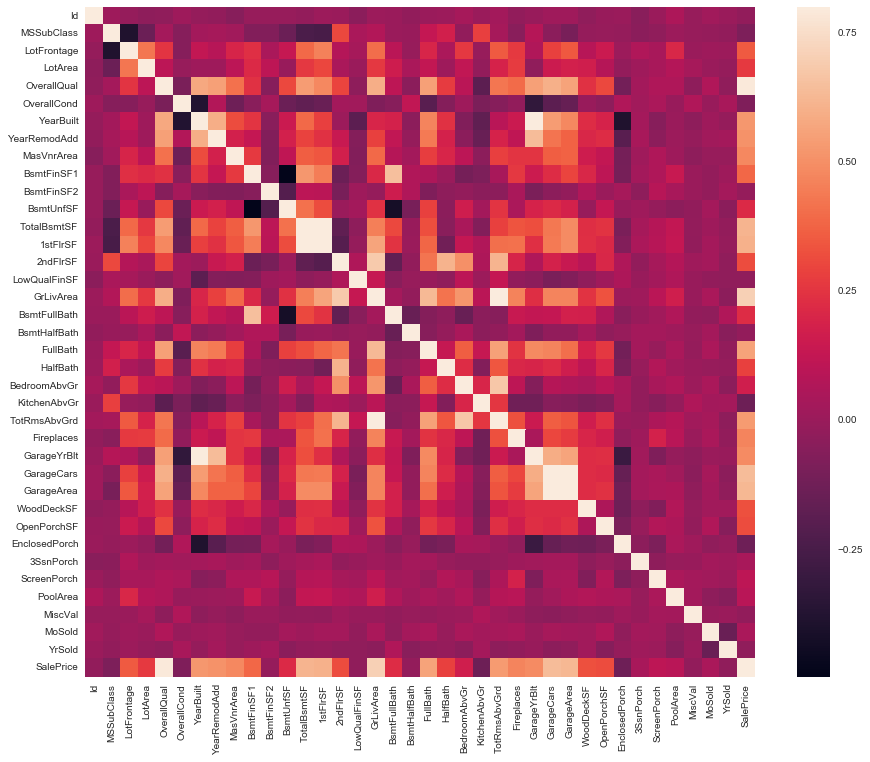

In [14]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

Let's narrow down to show top 20 features. The light grey area in the matrix means there are missing values for these variables. It's not a surprise to see that GrLivArea, GarageCars, TotalBsmtSF, 1stFirST, FullBath, TotRmsAbvGrd and YearBuilt have strong correlations with sales price. Some variables are highly correlated, such as GarageCars and GarageArea or TotRmsAbvGrd and GrLivArea.
Even though there are no strong correlation between Sale Price driven and YrSold, we think YrSold is an important variable reflecting the market condition and may have interactions with other variables. 

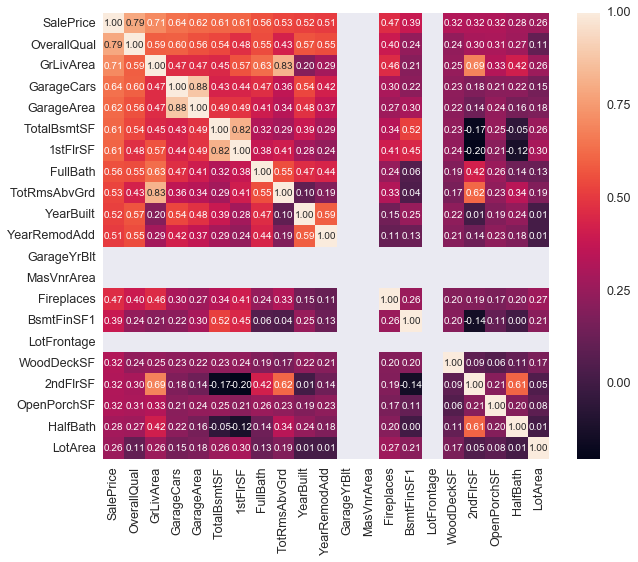

In [24]:
#saleprice correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
k = 21 #number of variables for heatmap
important_features = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[important_features].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=important_features.values, xticklabels=important_features.values)
plt.show()

We could further explore xy plots for these top 20 numeric features.

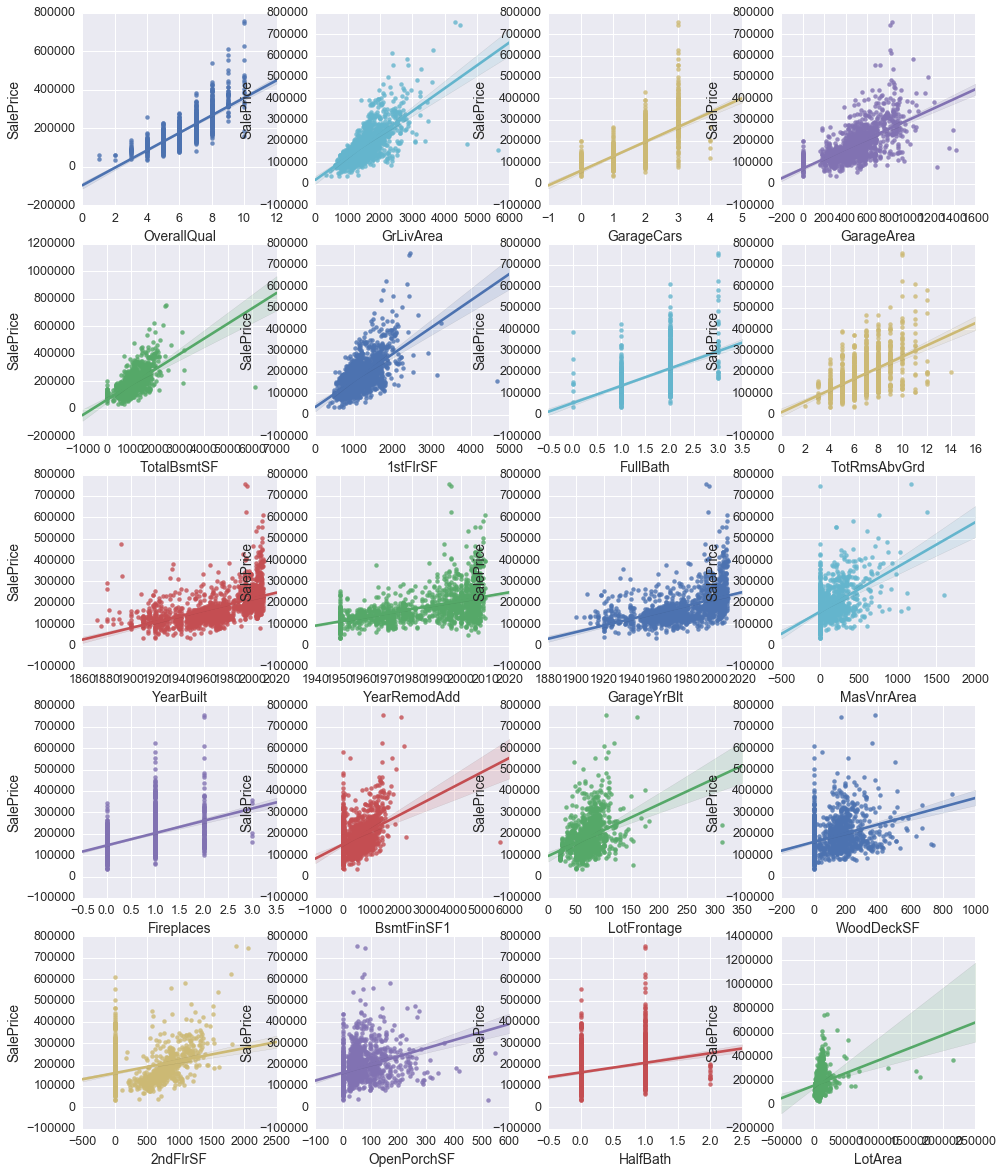

In [26]:
# Remove the label from the feature list because it's not a feature; it's the label
important_features = list(important_features)
important_features.remove('SalePrice')
# Reshape the feature list into a 5x4 ndarray so we can iterate through it in a grid
important_features_arr = np.array(important_features).reshape(5,4)
important_features_arr

# We'll do a 5x4 grid of subplots since we have 20 features
f, axs = plt.subplots(5,4)
f.set_size_inches(16,20)

for i in range(4):
    for j in range(5):
        sns.regplot(data=df, x=important_features_arr[j,i], y='SalePrice', ax=axs[j,i])

Observations:
* There are a few features where the slope is skewed by zero values of the feature. We may be able to benefit by creating new dummies for those and including them in the model. These features are GarageCars, WoodDeckSF, 2ndFlrSF, Fireplaces, TotalBsmtSF, etc.
* A few features have outliers that skew the fit. These features are: 1stFlrSF, LotArea, LotFrontage, TotalBsmtSF, and GrLivArea. These outliers may be removed before fit the model.

In [31]:
# we will remove these two outliers from modeling fit
df[(df['TotalBsmtSF']> 6000)|(df['1stFlrSF']> 4000)|(df['GrLivArea']> 5000)
   |(df['LotFrontage']> 300)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


### Sales Price vs. Categorical Variables

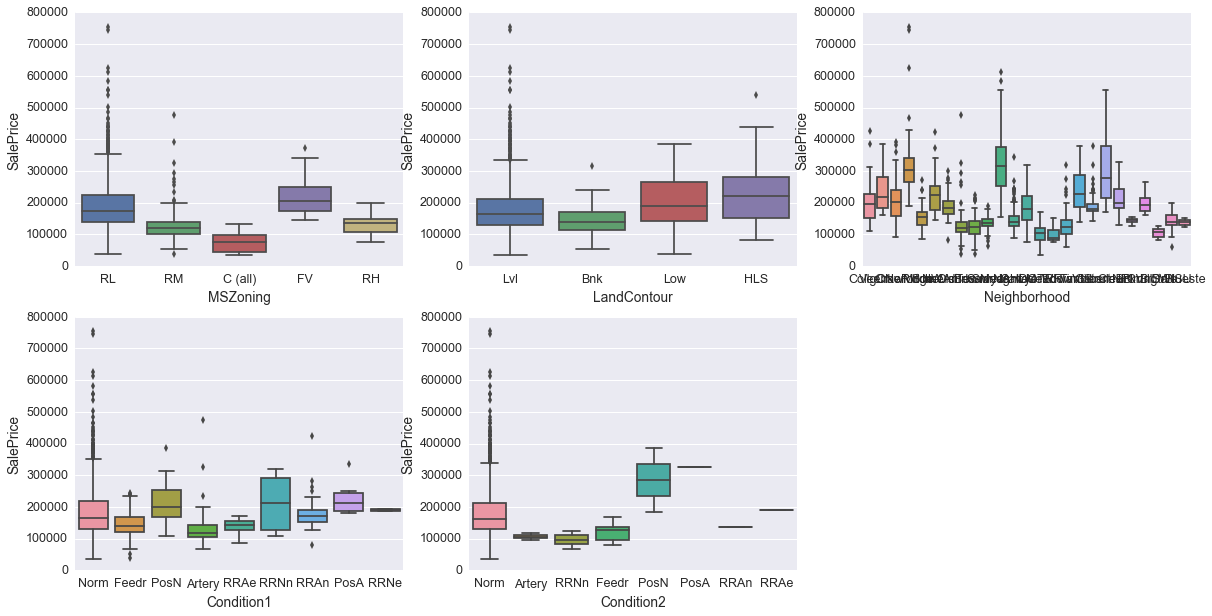

In [72]:
# relationship with categorical variables, using boxplot.
cat_cols_1 = ['MSZoning', 'LandContour', 'Neighborhood', 'Condition1', 'Condition2']
plt.figure(figsize=(20, 10))
for i  in range(len(cat_cols_1)):
    var = cat_cols_1[i]
    data = pd.concat([df['SalePrice'], df[var]], axis=1)
    p = plt.subplot(2, 3, i+1)
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);

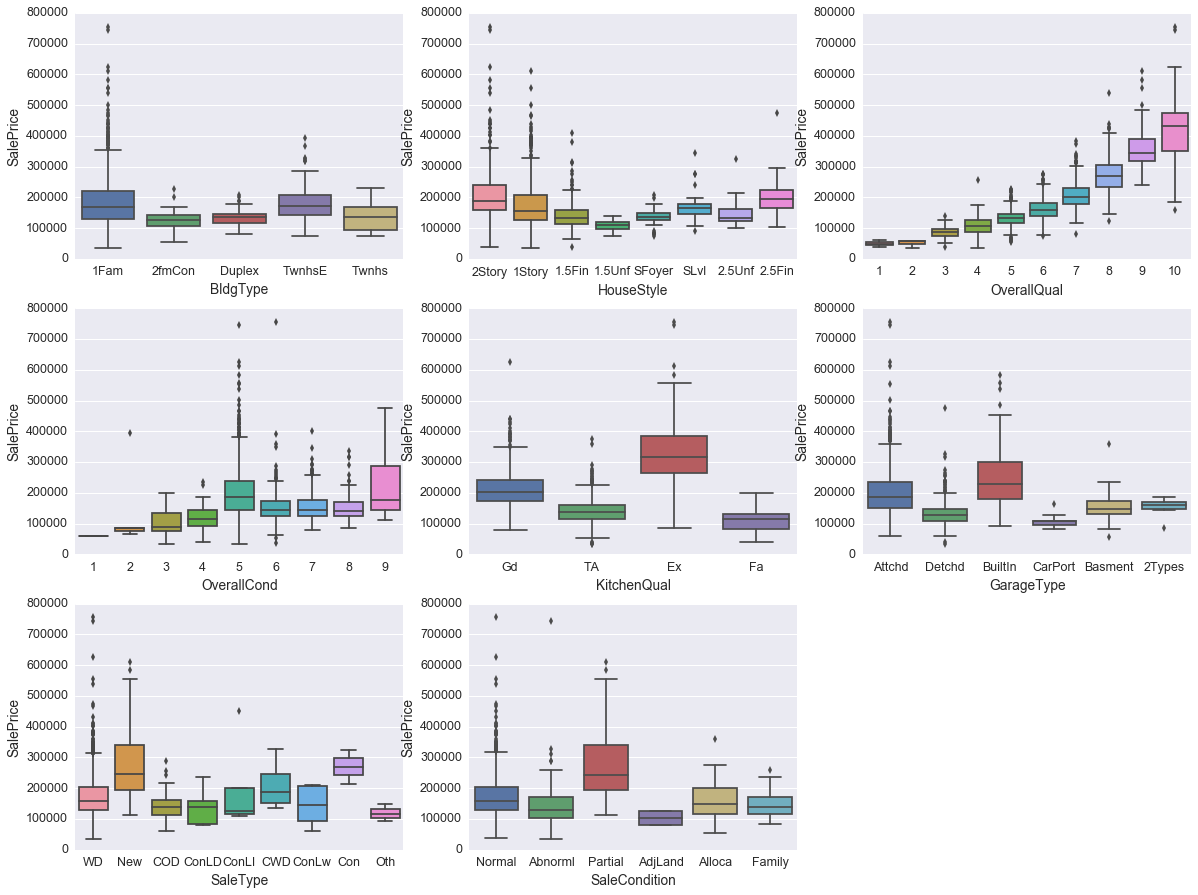

In [75]:
cat_cols_3 = ['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'KitchenQual'
              , 'GarageType', 'SaleType', 'SaleCondition']
plt.figure(figsize=(20, 15))
for i  in range(len(cat_cols_3)):
    var = cat_cols_3[i]
    data = pd.concat([df['SalePrice'], df[var]], axis=1)
    p = plt.subplot(3, 3, i+1)
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);

## Feature Engineering/Transform
need to apply the same transfomation to both original training data and test data!!!
but shall we use log tranform or just scale the variables, i don't think we need both. Perhaps the latter fit more models while log tranform is more appropriate for linear regression models.

use .components_ to see that
(PCA) --> feature selection  -->

** removing missing_featues --> impute missing values --> remove outliers --> Log transform skewed numerical variables
--> standardize numerical features --> create dummy variables for categorical variables --> create new features for zero-valued numeric variables --> combine all features --> (PCA) and check components --> other feature selection (i.e. L1 or variable importance) --> dataset for modeling **

** Remove Variables with high percentage of missing values **
1. removing variables with high percentage of missing values
2. Select important features and remove duplicate ones

In [ ]:
columns = df.columns.tolist()
missing_features = missing_data[missing_data['Percent'] > 0.15]
missing_features = list(missing_features.index)
for m in missing_features:
    columns.remove(m)
df = df[columns]
df.shape

** Create Dummy Variables for Numerical Variables with many Zero-values **

In [197]:
zero_value_ratio = df[numeric_features].apply(lambda x: np.sum(x ==0))*1.0/df.shape[0]
print(zero_value.sort_values(ascending=False)[:15])
# remove features with very high ratio of zero_value
zero_value_feature1 = list(zero_value_ratio[zero_value_ratio > 0.8].index)
for f in zero_value_feature1:
    columns.remove(f)
df = df[columns]
df.shape

PoolArea         0.995205
3SsnPorch        0.983562
LowQualFinSF     0.982192
MiscVal          0.964384
BsmtHalfBath     0.943836
ScreenPorch      0.920548
BsmtFinSF2       0.885616
EnclosedPorch    0.857534
HalfBath         0.625342
MasVnrArea       0.589726
dtype: float64


(1460, 67)

In [206]:
zero_value_feature2 = list(zero_value_ratio[(zero_value_ratio <= 0.8) & (zero_value_ratio > 0.3)].index)
new_name = ['Has'+f for f in zero_value_feature2]
for i in range(len(zero_value_feature2)):
    df[new_name[i]] = df[zero_value_feature2[i]] > 0

** Impute Missing Values and Remove Outliers**

In [167]:
# filling NA's with the mean of the column:
df = df.fillna(df.mean())
df = df[(df['TotalBsmtSF']<= 6000)&(df['1stFlrSF']<= 4000)&(df['GrLivArea']<= 5000)
   &(df['LotFrontage']<= 300)]

**Log transform skewed numerical variables**

It's not necessary.

In [152]:
#log transform the target:
# df["SalePrice"] = np.log1p(df["SalePrice"])

#log transform skewed numeric features:
# skewed_cols = df[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_cols = skewed_cols[skewed_cols > 0.75]
# skewed_cols = skewed_cols.index
# df[skewed_cols] = np.log1p(df[skewed_cols])
# skewed_cols

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

** Standardize Numerical Features **

In [217]:
stdSc = StandardScaler()
numeric_features = [f for f in numeric_features if f in columns]
df[numeric_features].head()
df[numeric_features] = stdSc.fit_transform(df[numeric_features])
df[numeric_features].head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold
0,-0.207142,1.050994,0.878668,0.511418,0.575425,-0.944591,-0.459303,-0.793434,1.161852,0.370333,...,-0.211454,0.912210,-0.951226,1.021157,0.311725,0.351000,-0.752176,0.216503,-1.599111,0.138777
1,-0.091886,0.156734,-0.429577,-0.574410,1.171992,-0.641228,0.466465,0.257140,-0.795163,-0.482512,...,-0.211454,-0.318683,0.600495,-0.104483,0.311725,-0.060731,1.626195,-0.704483,-0.489110,-0.614439
2,0.073480,0.984752,0.830215,0.323060,0.092907,-0.301643,-0.313369,-0.627826,1.189351,0.515013,...,-0.211454,-0.318683,0.600495,0.937776,0.311725,0.631726,-0.752176,-0.070361,0.990891,0.138777
3,-0.096897,-1.863632,-0.720298,-0.574410,-0.499274,-0.061670,-0.687324,-0.521734,0.937276,0.383659,...,-0.211454,0.296763,0.600495,0.812705,1.650307,0.790804,-0.752176,-0.176048,-1.599111,-1.367655
4,0.375148,0.951632,0.733308,1.364570,0.463568,-0.174865,0.199680,-0.045611,1.617877,1.299326,...,-0.211454,1.527656,0.600495,0.896086,1.650307,1.698485,0.780197,0.563760,2.100892,0.138777


** Convert Categorical Variables into Dummy Variables **

In [232]:
#convert categorical variable into dummy
# need to select categorical features first
categorical_features2 = [f for f in categorical_features if f in columns]
categorical_features2
df_dummy = pd.get_dummies(df[categorical_features2])
df_dummy.head()

['OverallQual']

** Combine Categorical and Numerical Features **

In [221]:
df1 = pd.concat([df[numeric_features], df_dummy, df[new_name]], axis=1)
df1.shape
df1.columns

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       ...
       'SaleCondition_Normal', 'SaleCondition_Partial', 'HasMasVnrArea',
       'HasBsmtFinSF1', 'Has2ndFlrSF', 'HasBsmtFullBath', 'HasHalfBath',
       'HasFireplaces', 'HasWoodDeckSF', 'HasOpenPorchSF'],
      dtype='object', length=269)

** Apply PCA on Combined Features ??**

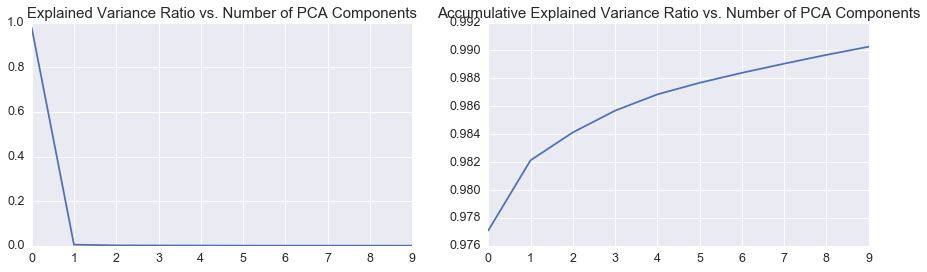

In [225]:
pca = PCA(n_components = 10)
df_pca = pca.fit_transform(df1)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio vs. Number of PCA Components")
plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Accumulative Explained Variance Ratio vs. Number of PCA Components")

In [28]:
# based on the explained variance ratio chart, we will use x PCA components
# which will explain almost 80% of the variances.
pca2 = PCA(n_components = 5)
df2 = pca2.fit_transform(df1)
pca2.components_

array([[-1.31905298,  0.28272875,  0.12533069, -1.02642164,  0.42559735,
         0.12070482, -0.01387882,  0.11097685, -0.26378356, -0.17620875],
       [ 0.70346544, -2.23076607, -0.99853674,  0.17744818, -0.58738307,
         0.01535017,  0.30005457,  0.38310142,  0.89318308,  0.08343007],
       [-1.31905298,  0.28272875,  0.12533069, -1.02642164,  0.42559735,
         0.12070482, -0.01387882,  0.11097685, -0.26378356, -0.17620875],
       [-1.05023268,  0.23177199,  0.95051753, -0.07447474,  0.43401099,
         0.55149831, -0.8096919 , -0.37273465, -0.05766652, -0.12585977],
       [-2.20300027,  0.06185562,  0.27796084, -0.90371169,  0.02423808,
         0.00382125, -0.04809595,  0.07849206, -0.07211301, -0.1329498 ]])

## Build Models and Tuning Parameter

We'll examine the performance of several models in predicting the label:
* Regularized Linear Regression
* Random Forest Regression
* Gradient Boosting Regression
* Support Vector Regression

For each model, we'll identify a set of values for one or more hyperparameters, and then we'll use Cross Validation & Grid Search to find the best set hyperparameters.

Then we will build ensemble model based on above individual models with fine-tuned hyperparameters.

** Split Data Sets **

In [235]:
# Partition the dataset in train + validation sets
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 269)
X_test : (438, 269)
y_train : (1022,)
y_test : (438,)


** Linear Regression **

MSE train: 323245739.724, test: 2290306343.803
R^2 train: 0.947, test: 0.663
Lasso picked 259 variables and eliminated the other 10 variables


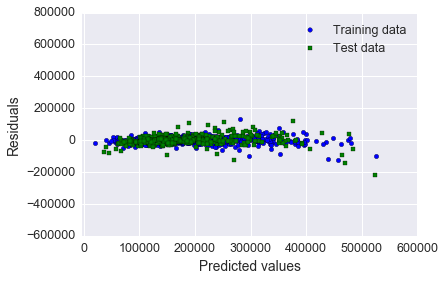

In [241]:
# LASSO regression
# L1 regulation, useful for feature selection
alpha = [0.0001, 0.05, 1.0] # alpha is quite import here
model_lasso = Lasso(alpha=0.1) 
model_lasso.fit(X_train, y_train)
test_pred_lasso = model_lasso.predict(X_test)
train_pred_lasso = model_lasso.predict(X_train)

print('MSE train: %.3f, test: %.3f' %
     (mean_squared_error(y_train, train_pred_lasso), mean_squared_error(y_test, test_pred_lasso)))
print('R^2 train: %.3f, test: %.3f' % 
     (r2_score(y_train, train_pred_lasso), r2_score(y_test, test_pred_lasso)))
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " 
      +  str(sum(coef == 0)) + " variables")

# residual plots
plt.scatter(train_pred_lasso, train_pred_lasso - y_train, c='blue', marker='o', label='Training data')
plt.scatter(test_pred_lasso, test_pred_lasso - y_test, c='green', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper right')
plt.xlim([-2500, 600000])
plt.show()

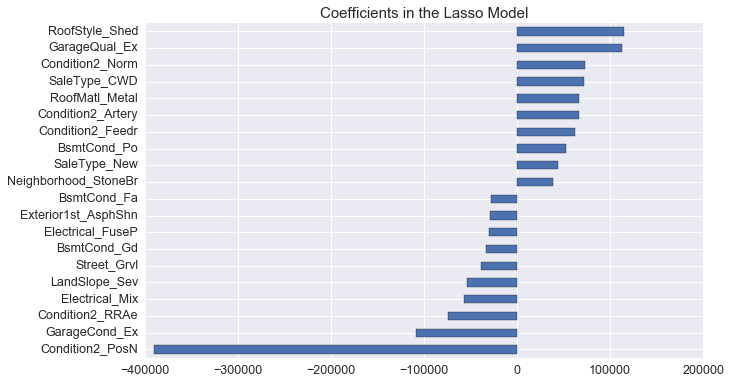

In [244]:
# check selected features by LASSO
plt.figure(figsize=(10, 6))
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

MSE train: 493573611.169, test: 1458440007.868
R^2 train: 0.919, test: 0.785


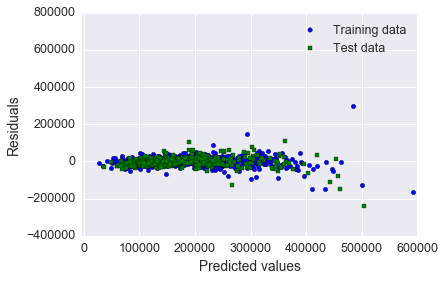

In [245]:
# Ridge regression (L2 regulation)
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] # alpha is regularization strength
model_ridge = Ridge(alpha=10.0)  
model_ridge.fit(X_train, y_train)
test_pred_ridge = model_ridge.predict(X_test)
train_pred_ridge = model_ridge.predict(X_train)

print('MSE train: %.3f, test: %.3f' %
     (mean_squared_error(y_train, train_pred_ridge), mean_squared_error(y_test, test_pred_ridge)))
print('R^2 train: %.3f, test: %.3f' % 
     (r2_score(y_train, train_pred_ridge), r2_score(y_test, test_pred_ridge)))

# residual plots
plt.scatter(train_pred_ridge, train_pred_ridge - y_train, c='blue', marker='o', label='Training data')
plt.scatter(test_pred_ridge, test_pred_ridge - y_test, c='green', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper right')
plt.xlim([-2500, 600000])
plt.show()

** Random Forecast **

In [246]:
depth = [2,5,10]
n_estimators =[10, 20, 50, 100, 200]
model_rf = RandomForestRegressor(n_estimators=20, max_depth=5)
model_rf.fit(X_train, y_train)
test_pred_rf = model_rf.predict(X_test)
train_pred_rf = model_rf.predict(X_train)

print('MSE train: %.3f, test: %.3f' %
     (mean_squared_error(y_train, train_pred_rf), mean_squared_error(y_test, test_pred_rf)))
print('R^2 train: %.3f, test: %.3f' % 
     (r2_score(y_train, train_pred_rf), r2_score(y_test, test_pred_rf)))

MSE train: 517957593.537, test: 1110475509.887
R^2 train: 0.915, test: 0.836


** SVM **

In [257]:
# accuracy quite sensitive to epsilon but not C!! 'poly' kernel works well
# depends on the features
epsilon = [0.01, 0.03, 0.05]
C = [1.0, 2.0, 5.0, 10.0]
model_svm = SVR(C=3.0, epsilon=0.001, kernel='poly') # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
model_svm.fit(X_train, y_train)
test_pred_svm = model_svm.predict(X_test)
train_pred_svm = model_svm.predict(X_train)

print('MSE train: %.3f, test: %.3f' %
     (mean_squared_error(y_train, train_pred_svm), mean_squared_error(y_test, test_pred_svm)))
print('R^2 train: %.3f, test: %.3f' % 
     (r2_score(y_train, train_pred_svm), r2_score(y_test, test_pred_svm)))


MSE train: 5095727532.496, test: 5922707691.396
R^2 train: 0.165, test: 0.128


** XGB Tree **

http://xgboost.readthedocs.org/en/latest/python/python_intro.html 
has issue installing and use xgboost package and will stick with sklearn packages

** Gradient Boosting Regression **

http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

MSE train: 190121435.413, test: 967684634.217
R^2 train: 0.969, test: 0.857


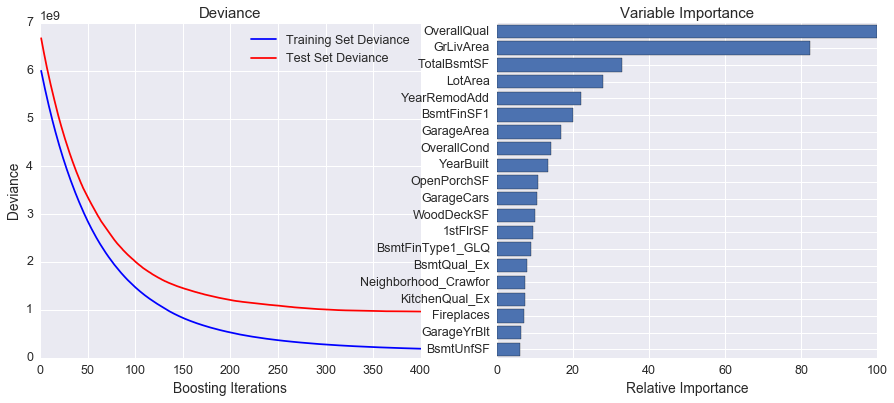

In [271]:
# Gradient Boosting Regression
params = {'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'} # least squares loss 
model_gbrt = GradientBoostingRegressor(**params)
model_gbrt.fit(X_train, y_train)

test_pred_gbrt = model_gbrt.predict(X_test)
train_pred_gbrt = model_gbrt.predict(X_train)

print('MSE train: %.3f, test: %.3f' %
     (mean_squared_error(y_train, train_pred_gbrt), mean_squared_error(y_test, test_pred_gbrt)))
print('R^2 train: %.3f, test: %.3f' % 
     (r2_score(y_train, train_pred_gbrt), r2_score(y_test, test_pred_gbrt)))

# Plot training deviance
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model_gbrt.staged_predict(X_test)):
    test_score[i] = model_gbrt.loss_(y_test, y_pred)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model_gbrt.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = model_gbrt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance) #ascending
sorted_idx = sorted_idx[len(sorted_idx)-20:len(sorted_idx)] # show top 20 features
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

** Ensemble **

use several model prediction to fit a linear regression model for the ensemble model instead of simple average of several model output.
1. regularized linear regression (L2)
2. Random Forecast
3. Gradient Boost Regression
4. SVM ?

In [274]:
model_ensemble = LinearRegression()
X_train_ensemble = pd.concat([pd.Series(train_pred_ridge),pd.Series(train_pred_rf),pd.Series(train_pred_gbrt)], axis=1)
X_test_ensemble = pd.concat([pd.Series(test_pred_ridge),pd.Series(test_pred_rf),pd.Series(test_pred_gbrt)], axis=1)

model_ensemble.fit(X_train_ensemble, y_train)
test_pred_ensemble = model_ensemble.predict(X_test_ensemble)
train_pred_ensemble = model_ensemble.predict(X_train_ensemble)
                             
print('MSE train: %.3f, test: %.3f' %
     (mean_squared_error(y_train, train_pred_ensemble), mean_squared_error(y_test, test_pred_ensemble)))
print('R^2 train: %.3f, test: %.3f' % 
     (r2_score(y_train, train_pred_ensemble), r2_score(y_test, test_pred_ensemble)))

MSE train: 142534643.800, test: 988639389.209
R^2 train: 0.977, test: 0.854


## Final Forecast

In [ ]:
# df_test = pd.read_csv("C:/Users/cyhu/Desktop/w207/W207_Summer/Final Project/test.csv")
# X_test = df_test[['GrLivArea','FullBath','HalfBath','BedroomAbvGr']].values
# # X_test = df_test.values
# # save the output to a csv file for submission
# test_lab_f = open("C:/Users/cyhu/Desktop/w207/W207_Summer/Final Project/test_labeled.csv", "w") # you will need to edit this directory

# test_lab_f.write("Id,SalePrice")

# idx = 1460
                 
# for pp in pred:
#     idx += 1
#     test_lab_f.write("\n")
#     test_lab_f.write(str(idx) + "," + str(int(pp)))
# test_lab_f.close()